In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

Using TensorFlow backend.


In [5]:
#training set file
df = pd.read_csv('/Users/e5pianos/Desktop/2020 SPRING/COMP4641/project/lt_hydrator/lt_oid_info_train.csv',dtype=str,encoding='unicode_escape')
df = df[pd.notnull(df['label'])]
df = df[pd.notnull(df['text'])]
#testing set file (prediction)
dft = pd.read_csv('/Users/e5pianos/Desktop/2020 SPRING/COMP4641/project/lt_hydrator/lt_oid_info_test.csv',dtype=str,encoding='unicode_escape')
dft = dft[pd.notnull(dft['text'])]

#input of the model will be text + quoted_text
df['full_text']=df['text'].fillna('') + ' ' + df['quoted_text'].fillna('')
dft['full_text']=dft['text'].fillna('') + ' ' + dft['quoted_text'].fillna('')

KeyError: 'quoted_text'

<Figure size 720x288 with 0 Axes>

0.0    512
1.0    259
2.0    179
3.0     49
Name: label, dtype: int64


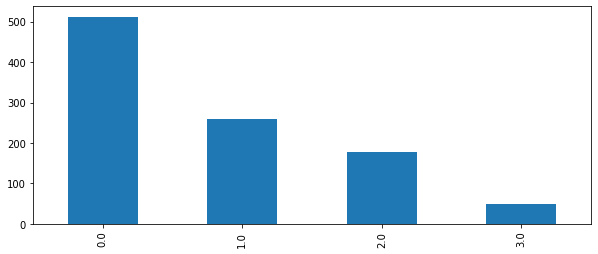

In [3]:
#statstic of classes
my_tags = ['0','1','2','3']
plt.figure(figsize=(10,4))
df.label.value_counts().plot(kind='bar');
print(df.label.value_counts())

In [4]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df['full_text'] = df['full_text'].apply(clean_text)
dft['full_text'] = dft['full_text'].apply(clean_text)

KeyError: 'full_text'

In [ ]:
df['full_text'].apply(lambda x: len(x.split(' '))).sum()
dft['full_text'].apply(lambda x: len(x.split(' '))).sum()

In [ ]:
X_train = df.full_text
y_train=df.label
X_test=dft.full_text
y_test=[]

In [6]:
####Naive Bayes classifier for multinomial models

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred = nb.predict(X_test)

#perdicting
        
idx=0
yl=[]
for i in X_test:
    yl.append(y_pred[idx])
    idx=idx+1
    
#CHANGE to your test files directory
df=pd.read_csv("./lt_hydrator/lt_oid_info_test.csv",dtype=str,encoding='unicode_escape')
df['label']=yl
df.to_csv( "./lt_hydrator/lt_oid_info_predicted.csv", index=False, encoding='utf-8-sig')



In [ ]:
########Linear support vector machine

from sklearn.linear_model import SGDClassifier
import sklearn

sgd = sklearn.pipeline.Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

#perdicting
        
idx=0
yl=[]
for i in X_test:
    yl.append(y_pred[idx])
    idx=idx+1
    
#CHANGE to your test files directory
df=pd.read_csv("./lt_hydrator/lt_oid_info_test.csv",dtype=str,encoding='unicode_escape')
df['label']=yl
df.to_csv( "./lt_hydrator/lt_oid_info_predicted.csv", index=False, encoding='utf-8-sig')




In [ ]:
########Logistic regression

from sklearn.linear_model import LogisticRegression


logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

#predicting
idx=0
yl=[]
for i in X_test:
    yl.append(y_pred[idx])
    print(y_pred[idx])
    idx=idx+1
    
#CHANGE to your test files directory
df=pd.read_csv("./lt_hydrator/lt_oid_info_test.csv",dtype=str,encoding='unicode_escape')
df['label']=yl
df.to_csv( "./lt_hydrator/lt_oid_info_predicted.csv", index=False, encoding='utf-8-sig')


In [7]:
###Word2vec embedding and Logistic Regression

from gensim.models import Word2Vec
from gensim import models
import gensim

#CHANGE to your library directory
wv = gensim.models.KeyedVectors.load_word2vec_format("/Users/e5pianos/Desktop/2020 SPRING/COMP4641/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [ ]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))
import nltk

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean
def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

train=df
test=dft
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['full_text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['full_text']), axis=1).values

In [ ]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['label'])
y_pred = logreg.predict(X_test_word_average)

#predicting
idx=0
yl=[]
for i in X_test_word_average:
    yl.append(y_pred[idx])
    print(y_pred[idx])
    idx=idx+1
    
#CHANGE to your test files directory
df=pd.read_csv("./lt_hydrator/lt_oid_info_test.csv",dtype=str,encoding='unicode_escape')
df['label']=yl
df.to_csv( "./lt_hydrator/lt_oid_info_predicted.csv", index=False, encoding='utf-8-sig')


In [8]:
###BOW with keras

import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils



train_posts = df['full_text']
train_tags = df['label']

test_posts = dft['full_text']
test_tags = []


In [ ]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


In [ ]:
batch_size = 32
epochs = 20

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

In [ ]:
#predicting

text_labels = encoder.classes_ 


yl=[]

for i in x_test:
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    yl.append(predicted_label)
    #print("Predicted label: " + predicted_label + "\n")
    
    
#CHANGE to your test files directory
df=pd.read_csv("./lt_hydrator/lt_oid_info_test.csv",dtype=str,encoding='unicode_escape')
df['label']=yl
df.to_csv( "./lt_hydrator/lt_oid_info_predicted.csv", index=False, encoding='utf-8-sig')


In [9]:
##Doc2vec and Logistic Regression

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import doc2vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import gensim


def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

X_train, X_test, y_train, y_test = df.full_text,df_label,dft_full_text,dft_label
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

In [ ]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [ ]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

In [ ]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

In [ ]:
#predicting
idx=0
yl=[]
for i in test_vectors_dbow:
    yl.append(y_pred[idx])
    print(y_pred[idx])
    idx=idx+1
    
#CHANGE to your test files directory
df=pd.read_csv("./lt_hydrator/lt_oid_info_test.csv",dtype=str,encoding='unicode_escape')
df['label']=yl
df.to_csv( "./lt_hydrator/lt_oid_info_predicted.csv", index=False, encoding='utf-8-sig')
